##### Imports

In [2]:
import asvFormula.bayesianNetworks.bayesianNetwork as bn
import asvFormula.experiments as exp
from asvFormula import asvRunResultsPath
from asvFormula.datasetManipulation import *
import asvFormula.ASV as exact
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

cancerApproximateASVFile = asvRunResultsPath + "/cancerASVAndShapleyApproximate.csv"
childApproximateASVFile = asvRunResultsPath + "/childASVAndShapleyApproximate.csv"

cancerExactASVFile = asvRunResultsPath + "/cancerASVAndShapleyExact.csv"
childExactASVFile = asvRunResultsPath + "/childASVAndShapleyExact.csv"

seeds = [12,32,53,420,5]

In [2]:
from importlib import reload 
import asvFormula
import asvFormula.bayesianNetworks.bayesianNetwork as bn
import asvFormula.ASV as exact
import asvFormula.experiments as exp

bn = reload(asvFormula.bayesianNetworks.bayesianNetwork)
exact = reload(asvFormula.ASV)
exp = reload(asvFormula.experiments)


## Generating the results 

### Running ASV for Cancer bayesian network

In [7]:
if os.path.exists(cancerApproximateASVFile):
    os.remove(cancerApproximateASVFile) #Remove the file to reset results
for seed in seeds:
    cancerBNmodel, variableToPredict, numberOfSamples, treeMaxDepth = exp.cancerNetworkConfig()

    BNInference, valuesPerFeature, encodedDataset, dtTreeClassifier, dtAsNetwork = initializeDataAndRemoveVariable(cancerBNmodel, variableToPredict, numberOfSamples, treeMaxDepth, seed)

    dataNoPrediction = encodedDataset.drop(variableToPredict, axis=1)
    first_instance = dataNoPrediction.iloc[0]

    asvCalc = exact.ApproximateASV(cancerBNmodel, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction='Exact')

    exp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, cancerApproximateASVFile , valuesPerFeature, variableToPredict, seed)

  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.8083333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7416666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7583333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.725


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7583333333333333


### Running ASV for Child bayesian network

In [2]:
if os.path.exists(childApproximateASVFile):
    os.remove(childApproximateASVFile) #Remove the file to reset results
for seed in seeds:
    treeBNChild, variableToPredict, numberOfSamples, treeMaxDepth = exp.childNetworkConfig()
    BNInference, valuesPerFeature, encodedDataset, dtTreeClassifier, dtAsNetwork = initializeDataAndRemoveVariable(treeBNChild, variableToPredict, numberOfSamples, treeMaxDepth, seed)

    dataNoPrediction = encodedDataset.drop(variableToPredict, axis=1)
    first_instance = dataNoPrediction.iloc[0]

    asvCalc = exact.ApproximateASV(treeBNChild, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction='Exact')

    exp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, childApproximateASVFile , valuesPerFeature, variableToPredict, seed)
    #This takes 20 minutes to run

  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6735


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6705


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.652


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6785


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6735


## Plotting the results 

### Converting to numerical data

In [5]:
dfCancerApproximateDict = exp.multipleSeedsDataframes(cancerApproximateASVFile, seeds)
dfCancerExactDict = exp.multipleSeedsDataframes(cancerExactASVFile, seeds)

dfChildAppproximateDict = exp.multipleSeedsDataframes(childApproximateASVFile, seeds)
dfChildExactDict = exp.multipleSeedsDataframes(childExactASVFile, seeds)

plotsResultsFolder = 'results/plots/'

### Plotting ASV values for each feature

In [ ]:
def plotASVandShapForSeeds(seeds, dfDict, hueValue):
    _, axes = plt.subplots(len(seeds), 2, figsize=(20, 15))
    for i, seed in enumerate(seeds):
        df = dfDict[seed]
        exp.plotASVandShapFromDF(df, hueValue, seed, None, axes[i])

    bayesianNetwork = 'cancer' if "Smoker value" == hueValue else 'child'
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f"{plotsResultsFolder}{bayesianNetwork}MultipleSeedsASVandShapleyApproximate.png")
    plt.show()

exp.plotASVandShapFromDF(dfCancerApproximateDict[12], 'Smoker value', 12, f"{plotsResultsFolder}{dfCancerApproximateDict[12].name}ASVAndShapley.png")
exp.plotASVandShapFromDF(dfChildAppproximateDict[420], 'Age value', 420, f"{plotsResultsFolder}{dfChildAppproximateDict[420].name}ASVAndShapley.png")

plotASVandShapForSeeds(seeds, dfCancerApproximateDict, 'Smoker value')
plotASVandShapForSeeds(seeds, dfChildAppproximateDict, 'Age value')


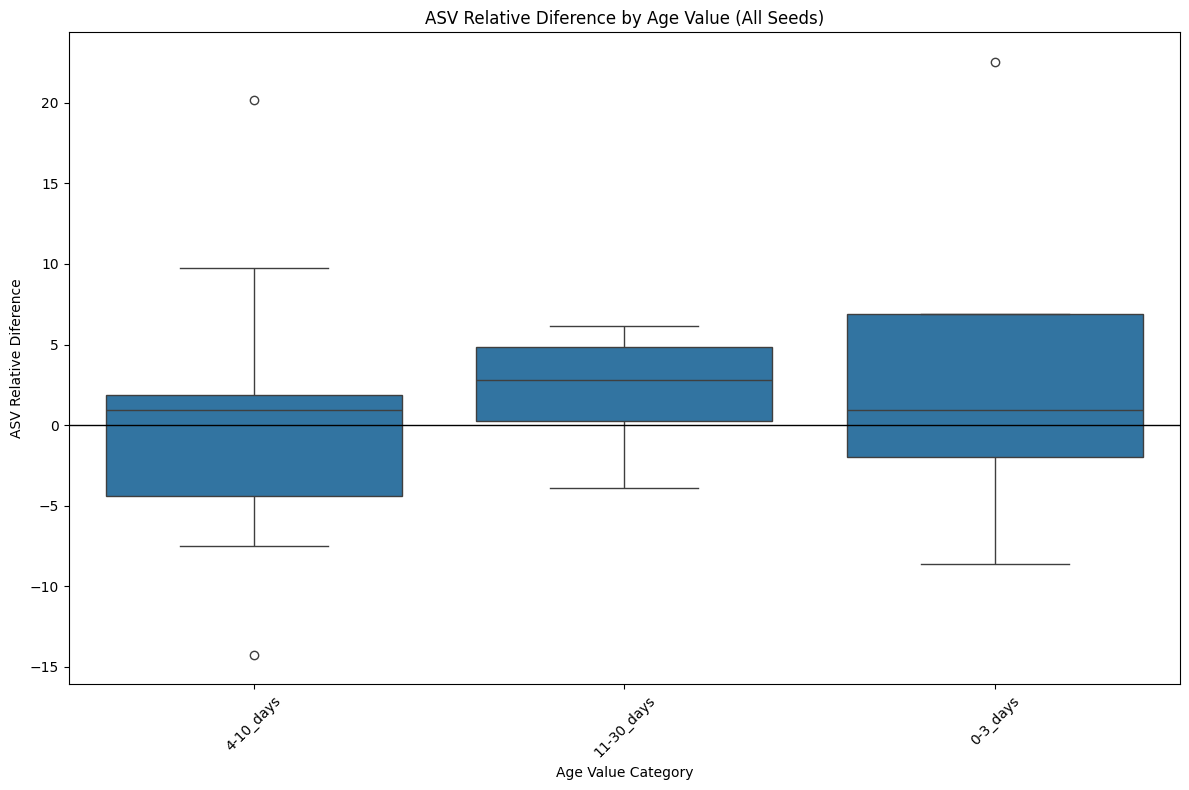

In [7]:
def calculateASVDifferences(dfExactDict: dict[int, pd.DataFrame], 
                            dfApproximateDict: dict[int, pd.DataFrame], 
                            seeds):

    all_merged = []

    for seed in seeds:
        exact_df = dfExactDict[seed]
        approx_df = dfApproximateDict[seed]

        predictedColumn = "Smoker" if 'cancer' in exact_df.name else "Age"
        merged = pd.merge(exact_df, approx_df, on=["Feature", f"{predictedColumn} value"], 
                          suffixes=("_exact", "_approx"))

        merged = merged[merged['ASV_approx'] > 0.005]

        merged["ASV_diff"] = (merged["ASV_exact"] - merged["ASV_approx"])

        merged["relative_difference"] = np.where(
            merged["ASV_exact"] != 0,
            (merged["ASV_diff"] / merged["ASV_exact"].abs()) * 100,
            np.nan
        )

        merged["Seed"] = seed

        all_merged.append(merged)

    # Concatenamos todos los merged en un único dataframe
    final_df = pd.concat(all_merged, ignore_index=True)

    # Plot global con todas las seeds
    plt.figure(figsize=(12, 8))
    sns.boxplot(
        data=final_df,
        x=f"{predictedColumn} value",   # "Age value"
        y="relative_difference"
    )

    plt.axhline(0, color="black", linewidth=1)
    plt.title("ASV Relative Diference by Age Value (All Seeds)")
    plt.ylabel("ASV Relative Diference")
    plt.xlabel("Age Value Category")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{plotsResultsFolder}ChildAllSeedsASVBoxplot.png")
    plt.show()


#calculateASVDifferences(dfCancerApproximateDict, dfCancerExactDict, seeds)
calculateASVDifferences(dfChildAppproximateDict, dfChildExactDict, seeds)


## Child toposorts generation experiment

In [5]:
treeBNChild, variableToPredict, numberOfSamples, treeMaxDepth = exp.childNetworkConfig()

In [6]:
import timeit
from itertools import islice
from asvFormula.topoSorts import allPolyTopoSorts


numberOfSamples = 30000000
allToposorts = allPolyTopoSorts(treeBNChild)
#timeForSamples = timeit.timeit(lambda: exact.randomTopoSorts(treeBNChild, numberOfSamples), number=1)
timeForClasses = timeit.timeit(lambda: exact.equivalenceClassesFor(treeBNChild, 'HypDistrib'), number=1)
timeForExact = timeit.timeit(lambda:  list(islice(nx.all_topological_sorts(treeBNChild), numberOfSamples)), number=1)


#print(allToposorts)
#print(f"Time for {numberOfSamples} samples: {timeForSamples}, which is a {round(numberOfSamples/allToposorts*100, 6)}% of total toposorts")
#print(f"Time taken for generating equivalence classes classes : {timeForClasses}")
print(f"Time for {numberOfSamples} exact generation of toposorts: {timeForExact}, which is a {round(numberOfSamples/allToposorts*100, 6)}% of total toposorts")



Time for 30000000 exact generation of toposorts: 728.4126399669999, which is a 0.004048% of total toposorts
